### librerias2

In [1]:
import matplotlib
matplotlib.use('TkAgg')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
%matplotlib inline
plt.rcParams['figure.figsize']=(8,2)
plt.style.use('ggplot')

# Base de Datos

In [4]:
datos = pd.read_csv('datos_depurados.csv')

df = pd.DataFrame(datos)
df.City = df.City.astype('category')
df.type = df.type.astype('category')
df2 = df.iloc[:, [2, 3, 4, 5, 6, 7]]
df2.head()

,finalACMPrice,originalPrice,area,bathrooms,rooms,garages
0,382.0,390.0,20,1,1,0
1,219.0,210.0,24,2,2,1
2,607.0,600.0,25,1,5,1
3,235.0,240.0,25,3,3,1
4,491.0,490.0,25,2,3,1


## Normalizar Datos:

In [5]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

df_mean_norm = mean_norm(df2)
df_mean_norm.head()

,finalACMPrice,originalPrice,area,bathrooms,rooms,garages
0,0.618621,0.671891,-1.152964,-1.237430,-2.218155,-0.825148
1,-0.456675,-0.516947,-1.079576,-0.046391,-1.092677,0.495964
2,2.102925,2.058869,-1.061229,-1.237430,2.283756,0.495964
3,-0.351125,-0.318808,-1.061229,1.144647,0.032801,0.495964
4,1.337684,1.332357,-1.061229,-0.046391,0.032801,0.495964


# Análisis de Componentes Principales (PCA)

## Encontrar número de dimensiones:

Text(0.5, 1.0, 'Eibow curve')

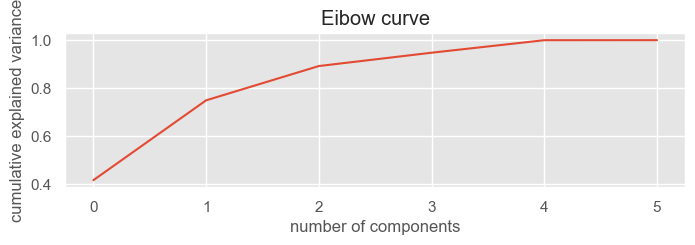

In [7]:
pca = PCA(n_components=6)
pca.fit(df_mean_norm)
x_pca = pca.transform(df_mean_norm)
expl = pca.explained_variance_ratio_

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Eibow curve')

## Realizar PCA con 3 dimensiones:

In [8]:
pca2 = PCA(n_components=3)
pca2.fit(df_mean_norm)
pca2.transform(df_mean_norm)

array([[-2.73975946,  0.87184111,  0.61437477],
       [-0.95620662, -0.69441353,  1.11327162],
       [-0.03871378,  2.93117142, -0.80906616],
       ...,
       [ 1.81866483,  3.61989533, -1.08845305],
       [ 1.81357021,  3.8905282 , -1.09290116],
       [11.17848295, -0.56270048, -0.04290915]])

# K-MEANS

## Encontrar numero de cluster:

Text(0.5, 1.0, 'K-means with PCA Clustering')

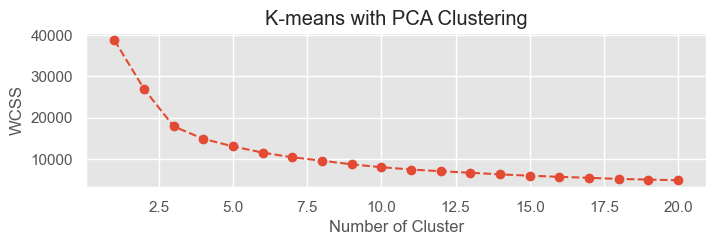

In [9]:
scores_pca = pca2.transform(df_mean_norm)
wcss = []

for i in range(1, 21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(8, 2))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')

## Implementar K-means:

In [10]:
k_means_pca2 = KMeans(n_clusters=5,init='k-means++',random_state=42)
k_means_pca2.fit(scores_pca)


KMeans(n_clusters=5, random_state=42)

## Análisis de Resultados:

Text(0.5, 1.0, 'Clusters by PCA Components')

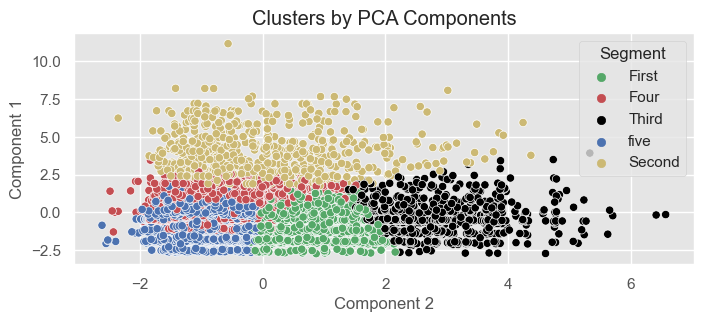

In [11]:
# Eiquetar componentes

df_segm_pca_kmeans = pd.concat([df_mean_norm.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']

# The last Column we add contains the pca K-means clustering labels

df_segm_pca_kmeans['Segment K-means PCA'] = k_means_pca2.labels_
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0: 'First',
                                                                               1: 'Second',
                                                                               2: 'Third',
                                                                               3: 'Four',
                                                                               4:'five'})

plt.figure(figsize=(8,3))
sns.scatterplot(x=df_segm_pca_kmeans['Component 2'], y=df_segm_pca_kmeans['Component 1'], hue=df_segm_pca_kmeans['Segment'], palette=['g', 'r','#000000','b','y'])
plt.title('Clusters by PCA Components')

#### Contar observaciones por cluster:

In [12]:
labels = k_means_pca2.predict(scores_pca)
# Getting the cluster centers
C = k_means_pca2.cluster_centers_
colores = ['g', 'r','#000000','b','y']
asignar = []
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(scores_pca[:, 0], scores_pca[:, 1], scores_pca[:, 2], c=asignar, s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)


copy = pd.DataFrame()
copy['City']= datos['City'].values
copy['label'] = labels
cantidadGrupo = pd.DataFrame()
cantidadGrupo['color']= colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,g,1665
1,r,626
2,#000000,841
3,b,1846
4,y,2262


<Figure size 800x200 with 0 Axes>

#### Mirar observaciones de algun cluster por alguna variable:

In [13]:
group_referrer_index = copy['label'] == 2
group_referrals = copy[group_referrer_index]

diversidadGrupo = pd.DataFrame()
diversidadGrupo['City'] = ['Bogotá','Medellín']
diversidadGrupo['Cantidad'] = group_referrals.groupby('City').size()
group_referrals.groupby('City').size()

City
BogotÃ¡      632
MedellÃ­n    209
dtype: int64

#### Inmuebles mas cercanos a los centroides:

In [14]:
#Posicion en el array de los inmuebles
closest,_= pairwise_distances_argmin_min(k_means_pca2.cluster_centers_,scores_pca)

#Numero de inmuebles
inmuebles= datos['Unnamed: 0'].values

for row in closest:
    print(inmuebles[row])

2976
6917
1082
5789
287


#### Clasificar nuevos inmuebles:

In [15]:
x_new=np.array([[1.71,1.95,-0.89]])
new_labels2= k_means_pca2.predict(x_new)

new_labels2

array([2])

In [16]:
cluster=df_segm_pca_kmeans['Segment']
cluster=pd.DataFrame(cluster)

In [17]:
acp=pca2.transform(df_mean_norm)
acp=pd.DataFrame(acp)
acp

,0,1,2
0,-2.739759,0.871841,0.614375
1,-0.956207,-0.694414,1.113272
2,-0.038714,2.931171,-0.809066
3,0.265564,-0.474755,0.489621
4,-0.446717,1.881415,0.449322
...,...,...,...
7235,2.342865,2.211183,0.032566
7236,1.837914,2.598095,-1.071523
7237,1.818665,3.619895,-1.088453
7238,1.813570,3.890528,-1.092901


In [18]:
df_final=pd.concat([df,cluster,acp],axis=1)
df_final=df_final.iloc[:,1:]
df_final=df_final.rename({0:'Comp 1',1:'Comp 2',2:'Comp 3'},axis=1)
df_final

,id,finalACMPrice,originalPrice,area,bathrooms,rooms,garages,type,City,location,Segment,Comp 1,Comp 2,Comp 3
0,21654,382.0,390.0,20,1,1,0,APA,BogotÃ¡,POINT (4.75155221 -74.05725996),First,-2.739759,0.871841,0.614375
1,10357,219.0,210.0,24,2,2,1,CAS,BogotÃ¡,POINT (4.5834460258484 -74.155975341797),Four,-0.956207,-0.694414,1.113272
2,8682,607.0,600.0,25,1,5,1,CAS,BogotÃ¡,POINT (-74.03879480426 4.6974971384783),Third,-0.038714,2.931171,-0.809066
3,6919,235.0,240.0,25,3,3,1,CAS,MedellÃ­n,POINT (-74.084359109402 4.7465266294171),Four,0.265564,-0.474755,0.489621
4,11824,491.0,490.0,25,2,3,1,APA,BogotÃ¡,POINT (6.2439528 -75.58545),Third,-0.446717,1.881415,0.449322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7235,16792,515.0,520.0,300,2,3,1,CAS,BogotÃ¡,POINT (4.721863 -74.03642),Third,2.342865,2.211183,0.032566
7236,33535,564.0,560.0,300,2,3,0,APA,MedellÃ­n,POINT (6.1798535721365 -75.586581230164),Third,1.837914,2.598095,-1.071523
7237,33522,675.0,668.0,300,2,3,0,CAS,MedellÃ­n,POINT (4.8687603369878 -74.061080472327),Third,1.818665,3.619895,-1.088453
7238,33995,701.0,700.0,300,2,3,0,APA,BogotÃ¡,POINT (4.7442904 -74.0665878),Third,1.813570,3.890528,-1.092901


In [21]:
df_final.to_excel('datos_shape.xlsx')